# YOUR PROJECT TITLE

> **Note the following:** 
> 1. This is *not* meant to be an example of an actual **data analysis project**, just an example of how to structure such a project.
> 1. Remember the general advice on structuring and commenting your code
> 1. The `dataproject.py` file includes a function which can be used multiple times in this notebook.

Imports and set magics:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from matplotlib_venn import venn2
import plotly.graph_objects as go
import glob
# autoreload modules when code is run
%load_ext autoreload
%autoreload 2
# user written modules
import dataproject
from pandas_datareader import wb
import seaborn as sns

# Read and clean data

Import your data, either through an API or manually, and load it. 

In [6]:
data = pd.read_csv('Population estimates 1992-2001.csv')
data = pd.merge(data, pd.read_csv('Population estimates 2002-2019.csv'), how='outer',validate='one_to_one')

In [7]:
data.head()

,Age,Sex,1992,1993,1994,1995,1996,1997,1998,1999,...,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,0,Males,262256,293100,281875,274171,269122,273472,273404,270959,...,289377,284926,276371,274396,263091,257024,248474,241228,234151,221685
1,0,Females,248552,277354,266660,258677,253857,258096,258674,255666,...,272945,268292,260976,259651,249049,242916,234503,228728,220915,209322
2,0,Total,510808,570454,548535,532848,522979,531568,532078,526625,...,562322,553218,537347,534047,512140,499940,482977,469956,455066,431007
3,1,Males,267914,264589,292378,280911,273119,268728,271549,270301,...,292642,288996,284199,277263,274308,262728,256954,248341,241422,234386
4,1,Females,255186,251203,276723,265953,258026,253591,256424,255967,...,277321,272698,267521,261900,259608,248720,242753,234634,228990,221360


In [8]:
#rename variables to be more informative and easier to work with
col_dict = {}
for i in range(1992, 2019+1):
    col_dict[str(i)] = f'pop{i}'

col_dict = {str(i) : f'pop{i}' for i in range(1992, 2019+1)}

data.rename(columns = col_dict, inplace=True)
data.head()

,Age,Sex,pop1992,pop1993,pop1994,pop1995,pop1996,pop1997,pop1998,pop1999,...,pop2010,pop2011,pop2012,pop2013,pop2014,pop2015,pop2016,pop2017,pop2018,pop2019
0,0,Males,262256,293100,281875,274171,269122,273472,273404,270959,...,289377,284926,276371,274396,263091,257024,248474,241228,234151,221685
1,0,Females,248552,277354,266660,258677,253857,258096,258674,255666,...,272945,268292,260976,259651,249049,242916,234503,228728,220915,209322
2,0,Total,510808,570454,548535,532848,522979,531568,532078,526625,...,562322,553218,537347,534047,512140,499940,482977,469956,455066,431007
3,1,Males,267914,264589,292378,280911,273119,268728,271549,270301,...,292642,288996,284199,277263,274308,262728,256954,248341,241422,234386
4,1,Females,255186,251203,276723,265953,258026,253591,256424,255967,...,277321,272698,267521,261900,259608,248720,242753,234634,228990,221360


In [9]:
#reshape data from wide to long format
pop_italy = pd.wide_to_long(data, stubnames='pop', i=['Age','Sex'], j='year')
pop_italy = pop_italy.reset_index()
pop_italy.head(10)

,Age,Sex,year,pop
0,0,Males,1992,262256
1,0,Males,1993,293100
2,0,Males,1994,281875
3,0,Males,1995,274171
4,0,Males,1996,269122
5,0,Males,1997,273472
6,0,Males,1998,273404
7,0,Males,1999,270959
8,0,Males,2000,272792
9,0,Males,2001,274518


In [10]:
#as we can see the column age is not in the right format. We need to change it to int but we have to deal with the '100 and other' and 'Total' observations 
pop_italy.info()

#we can drop the observation relative to the total  
pop_italy = pop_italy[pop_italy['Age'] != 'Total']
pop_italy = pop_italy[pop_italy['Sex'] != 'Total']

#Since 100 or other will be included in the same group of 100. we replace the '100 and other' with 100
pop_italy['Age'] = pop_italy['Age'].replace('100 and over', '100')

#Now we can change the column to int
pop_italy['Age'] = pop_italy['Age'].astype(int)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8568 entries, 0 to 8567
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Age     8568 non-null   object
 1   Sex     8568 non-null   object
 2   year    8568 non-null   int64 
 3   pop     8568 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 267.9+ KB


In [11]:
# Let's reshape the data to wide format again
pop_italy_wide = pop_italy.pivot(index=['year','Age'], columns='Sex', values='pop')
pop_italy_wide.sort_values(['year','Age'], inplace=True)
pop_italy_wide.reset_index(inplace=True)
pop_italy_wide.columns.name = None
pop_italy_wide.head(10)

,year,Age,Females,Males
0,1992,0,248552,262256
1,1992,1,255186,267914
2,1992,2,257770,270613
3,1992,3,259784,273681
4,1992,4,254547,267722
5,1992,5,257606,270798
6,1992,6,269742,281702
7,1992,7,274275,286983
8,1992,8,281761,295917
9,1992,9,293124,305422


In [12]:
#let's now add year equal to 2020 and 2021
data_2020 = pd.read_csv('Resident_population_2020.csv')
data_2020['year'] = 2020
data_2021 = pd.read_csv('Resident_population_2021.csv')
data_2021['year'] = 2021

data_new = pd.concat([data_2020, data_2021], ignore_index=True)

#rename variables in order to have the same names of the other dataset with which I have to append
data_new.rename(columns = {'Total males' : 'Males', 'Total females': 'Females'}, inplace=True)

#drop column total
data_new.drop(columns = ['Total'], inplace=True)

In [13]:
#creating a dataset that contains the population from 1991 to 2021
pop_italy = pd.concat([pop_italy_wide, data_new], ignore_index=True)

In [14]:
#as we can see the column age is not in the right format. We need to change it to int but we have to deal with the '100 and other' and 'Total' observations 
pop_italy.info()

#we can drop the observation relative to the total  
pop_italy = pop_italy[pop_italy['Age'] != 'Total']

#Since 100 or other will be included in the same group of 100. we replace the '100 and other' with 100
pop_italy['Age'] = pop_italy['Age'].replace('100 and over', '100')

#Now we can change the column to int
pop_italy['Age'] = pop_italy['Age'].astype(int)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3032 entries, 0 to 3031
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   year     3032 non-null   int64 
 1   Age      3032 non-null   object
 2   Females  3032 non-null   int64 
 3   Males    3032 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 94.9+ KB


In [15]:
# Create a new column with the age group of each observation
pop_italy['age_group'] = ''

for i in range(0, 101, 5):
    if i == 100:
        pop_italy.loc[pop_italy['Age'].between(i, i+5), 'age_group'] = '100-100+'
    else:
        pop_italy.loc[pop_italy['Age'].between(i, i+4), 'age_group'] = f'{i}-{i+4}'

# Summing up all the observations for each age group
pop_italy_agg = pop_italy.groupby(['age_group', 'year'])[['Males', 'Females']].sum()

# Resetting index
pop_italy_agg.reset_index(inplace=True)

# Splitting age_group into lower_bound and upper_bound in order to sort the age groups correctly
pop_italy_agg[['lower_bound', 'upper_bound']] = pop_italy_agg['age_group'].str.split('-', expand=True)

# Sorting the age groups
pop_italy_agg['lower_bound'] = pop_italy_agg['lower_bound'].astype(int)
pop_italy_agg.sort_values(['year','lower_bound'], inplace=True)
pop_italy_agg.reset_index(inplace=True)
pop_italy_agg.drop(['index', 'lower_bound', 'upper_bound'], axis=1, inplace=True)



In [16]:


def plot_func(df, year):
    I = df['year'] == year
    fig = go.Figure()
    # Adding male population data as positive values
    fig.add_trace(go.Bar(
        y=df.loc[I, 'age_group'],
        x=df.loc[I, 'Males'],
        name='Male',
        orientation='h'
    ))

    # Adding female population data as negative values to plot in opposite direction
    fig.add_trace(go.Bar(
        y=df.loc[I, 'age_group'],
        x=df.loc[I, 'Females'] * -1,  # Multiplying by -1 to plot in opposite direction
        name='Female',
        orientation='h'
    ))
    
    fig.update_layout(
        template='plotly_white',
        title=f'Population in Italy {year}',
        title_font_size=24,
        barmode='relative',
        bargap=0.1,  # Adjust as needed
        bargroupgap=0.2,  # Adjust as needed
        xaxis_title='Population',
        xaxis=dict(
            tickvals=[-2000000, -1000000, 0, 1000000, 2000000],
            ticktext=['2M', '1M', '0', '1M', '2M']
        ),
        width=800,
        height=600,
      
    )
    fig.show()

# Create an interactive widget with a slider to choose the year
widgets.interact(plot_func,
                 df=widgets.fixed(pop_italy_agg),
                 year=widgets.IntSlider(description='Year',
                                        min=pop_italy_agg['year'].min(),
                                        max=pop_italy_agg['year'].max(),
                                        step=1,
                                        value=pop_italy_agg['year'].min(),
                                        continuous_update=True
                                     )
                )


interactive(children=(IntSlider(value=1992, description='Year', max=2021, min=1992), Output()), _dom_classes=(…

<function __main__.plot_func(df, year)>

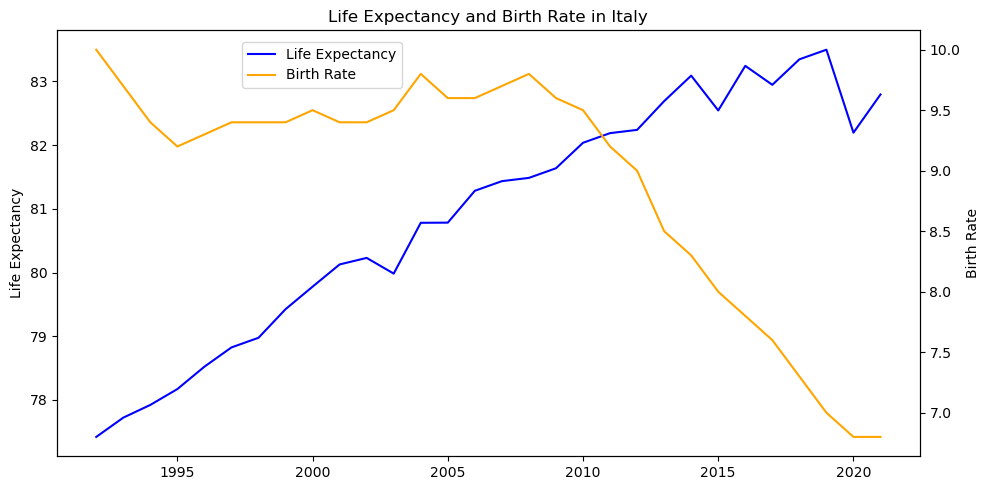

In [17]:
# Downloading life expectancy data for Italy
wb_fr = wb.download(indicator='SP.DYN.LE00.IN', country=['IT'], start=1992, end=2021)
wb_fr.reset_index(inplace=True)
wb_fr.rename(columns={'SP.DYN.LE00.IN': 'life_expectancy'}, inplace=True)
wb_fr['year'] = wb_fr['year'].astype(int)

# Downloading birth rate data for Italy
wb_birth = wb.download(indicator='SP.DYN.CBRT.IN', country=['IT'], start=1992, end=2021)
wb_birth.reset_index(inplace=True)
wb_birth.rename(columns={'SP.DYN.CBRT.IN': 'birth_rate'}, inplace=True)
wb_birth['year'] = wb_birth['year'].astype(int)

# Merging dataframes on 'year'
merged_df = pd.merge(wb_fr, wb_birth, on='year')

# Creating a figure and axis object
fig, ax1 = plt.subplots(figsize=(10, 5))

# Plotting life expectancy on primary y-axis
ax1.plot(merged_df['year'], merged_df['life_expectancy'], color='blue', label='Life Expectancy')
ax1.set_ylabel('Life Expectancy', color='black')

# Creating a secondary y-axis for birth rate
ax2 = ax1.twinx()
ax2.plot(merged_df['year'], merged_df['birth_rate'], color='orange', label='Birth Rate')
ax2.set_ylabel('Birth Rate', color='black')

# Adding title and legend
plt.title('Life Expectancy and Birth Rate in Italy')
fig.tight_layout()
fig.legend(loc='upper left', bbox_to_anchor=(0.24, 0.92))                                 
plt.show()


In [18]:
##need to find a way to import it with ., I dont know why it does not work if I write "decial = ","".



# Read the CSV file
regional_fertility = pd.read_csv('Fertility.csv')
regional_fertility.head()

# Function to insert dot after first digit in a string
def insert_dot(value):
    return str(value)[:1] + '.' + str(value)[1:]

# Apply the function to the '2021' column
regional_fertility['2021'] = regional_fertility['2021'].apply(lambda x: insert_dot(x))
# Convert the '2021' column to integers
regional_fertility['2021'] = regional_fertility['2021'].astype(float)

# Keep only variables 'territory' and '2021'
regional_fertility = regional_fertility.loc[:, ['Territory', '2021']]
regional_fertility.loc[regional_fertility['Territory'] == 'Sardegna', '2021'] = 0.99
# Display the modified DataFrame
regional_fertility.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23 entries, 0 to 22
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Territory  23 non-null     object 
 1   2021       23 non-null     float64
dtypes: float64(1), object(1)
memory usage: 500.0+ bytes


/Users/iariorlandi/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



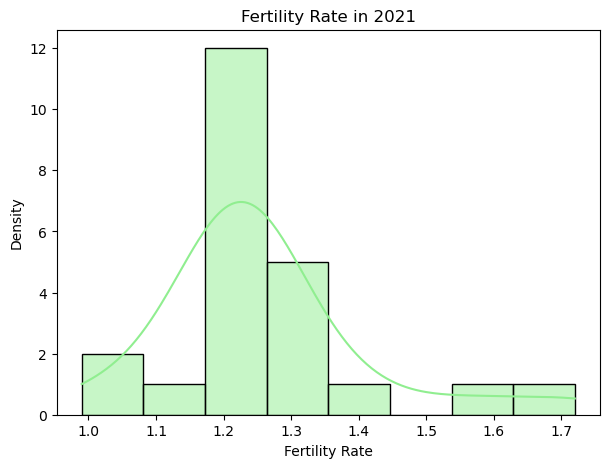

In [19]:
# Create subplots for comparison
plt.figure(figsize=(7, 5))

# Subplot for Fertility Rate
plt.subplot(1, 1, 1)  
sns.histplot(data=regional_fertility, x='2021', bins=8, kde=True, color='lightgreen')
plt.xlabel('Fertility Rate')
plt.ylabel('Density')
plt.title('Fertility Rate in 2021')
plt.show()

## Explore each data set

# Analysis

To get a quick overview of the data, we show some **summary statistics** on a meaningful aggregation. 

MAKE FURTHER ANALYSIS. EXPLAIN THE CODE BRIEFLY AND SUMMARIZE THE RESULTS.

# Conclusion

ADD CONCISE CONLUSION.